In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
info_path="../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype.csv")

# Prepare light curves for model fitting

This is a playground to develop the function necessary to create light curves for ingestion into the model-fitting procedure designed to determine the time of first light and parameters of the early rise.

In [88]:
rel_flux_cutoff = 0.4
flux_scale = 100
    
for filenum, sn in enumerate(salt_df.name.values):
    lc_df = pd.read_hdf(info_path+"{}_force_phot.h5".format(sn))
    t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
    z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
    g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
    r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)
    g_obs = np.where(lc_df['filter'] == b'g')
    r_obs = np.where(lc_df['filter'] == b'r')
    time_rf = (lc_df['jdobs'].values - t_max)/(1+z)        
    baseline = np.where(time_rf < -20)
    has_baseline = np.ones_like(time_rf).astype(bool)
    fmcmc = lc_df['Fmcmc'].values
    fmcmc_unc = lc_df['Fmcmc_unc'].values
    zp = lc_df.zp.values
    zp_unc = lc_df.ezp.values
    around_peak = np.where(np.abs(time_rf) <=4)
    
    f_zp = np.zeros_like(fmcmc)
    f_zp_unc = np.zeros_like(fmcmc)
    zp_base = np.zeros_like(fmcmc)
    
    for fcqfid in np.unique(lc_df.fcqfid.values):
        this_chip = np.where(lc_df.fcqfid.values == fcqfid)
        this_baseline = np.intersect1d(baseline, this_chip)
        
        if len(this_baseline) >= 1:
            zp_base[this_chip] = np.median(fmcmc[this_baseline]/10**(0.4*zp[this_baseline]))

            f_zp[this_chip] = fmcmc[this_chip]/10**(0.4*zp[this_chip])
            f_zp_unc[this_chip] = np.hypot(fmcmc_unc[this_chip]/10**(0.4*zp[this_chip]), 
                                             np.log(10)/2.5*fmcmc[this_chip]*zp_unc[this_chip]/10**(0.4*zp[this_chip]))
        else:
            has_baseline[this_chip] = 0
            print(sn, fcqfid, np.unique(lc_df.fcqfid.values))
            

    f_zp[g_obs] = f_zp[g_obs]/g_max
    f_zp[r_obs] = f_zp[r_obs]/r_max
    f_zp_unc[g_obs] = f_zp_unc[g_obs]/g_max
    f_zp_unc[r_obs] = f_zp_unc[r_obs]/r_max
    
    cutoff_g = np.where((time_rf[g_obs] < -5) & 
                       (f_zp[g_obs]-zp_base[g_obs]/g_max < rel_flux_cutoff))
    t_cut_g = time_rf[g_obs][cutoff_g[0][-1]] + 0.5
    early_g = np.where(time_rf[g_obs] < t_cut_g)
    cutoff_r = np.where((time_rf[r_obs] < -5) & 
                       (f_zp[r_obs]-zp_base[r_obs]/r_max < rel_flux_cutoff))
    t_cut_r = time_rf[r_obs][cutoff_r[0][-1]] + 0.5
    early_r = np.where(time_rf[r_obs] < t_cut_r)
    early_obs = np.append(g_obs[0][early_g], r_obs[0][early_r])

    return_obs = np.intersect1d(np.where(has_baseline > 0), early_obs)
    not_included = np.setdiff1d(range(len(f_zp)), return_obs)
    
#     time_rf[return_obs], f_zp[return_obs]*flux_scale, f_zp_unc[return_obs]*flux_scale, lc_df.fcqfid.values[return_obs]

ZTF18aauhxce 7541421.0 [7541421. 7541422. 7890331. 7890332.]


In [89]:
def prep_light_curve(sn, salt_df, rel_flux_cutoff=0.4, flux_scale = 100):
    
    # salt data
    t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
    z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
    g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
    r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

    # light curve data
    lc_df = pd.read_hdf(info_path+"{}_force_phot.h5".format(sn))
    g_obs = np.where(lc_df['filter'] == b'g')
    r_obs = np.where(lc_df['filter'] == b'r')
    time_rf = (lc_df['jdobs'].values - t_max)/(1+z)        
    baseline = np.where(time_rf < -20)
    has_baseline = np.ones_like(time_rf).astype(bool)
    fmcmc = lc_df['Fmcmc'].values
    fmcmc_unc = lc_df['Fmcmc_unc'].values
    zp = lc_df.zp.values
    zp_unc = lc_df.ezp.values
    
    f_zp = np.zeros_like(fmcmc)
    f_zp_unc = np.zeros_like(fmcmc)
    zp_base = np.zeros_like(fmcmc)
    
    for fcqfid in np.unique(lc_df.fcqfid.values):
        this_chip = np.where(lc_df.fcqfid.values == fcqfid)
        this_baseline = np.intersect1d(baseline, this_chip)
        
        if len(this_baseline) >= 1:
            zp_base[this_chip] = np.median(fmcmc[this_baseline]/10**(0.4*zp[this_baseline]))

            f_zp[this_chip] = fmcmc[this_chip]/10**(0.4*zp[this_chip])
            f_zp_unc[this_chip] = np.hypot(fmcmc_unc[this_chip]/10**(0.4*zp[this_chip]), 
                                             np.log(10)/2.5*fmcmc[this_chip]*zp_unc[this_chip]/10**(0.4*zp[this_chip]))
        else:
            has_baseline[this_chip] = 0
            print(sn, fcqfid, np.unique(lc_df.fcqfid.values))
            

    f_zp[g_obs] = f_zp[g_obs]/g_max
    f_zp[r_obs] = f_zp[r_obs]/r_max
    f_zp_unc[g_obs] = f_zp_unc[g_obs]/g_max
    f_zp_unc[r_obs] = f_zp_unc[r_obs]/r_max
    
    cutoff_g = np.where((time_rf[g_obs] < -5) & 
                       (f_zp[g_obs]-zp_base[g_obs]/g_max < rel_flux_cutoff))
    t_cut_g = time_rf[g_obs][cutoff_g[0][-1]] + 0.5
    early_g = np.where(time_rf[g_obs] < t_cut_g)
    cutoff_r = np.where((time_rf[r_obs] < -5) & 
                       (f_zp[r_obs]-zp_base[r_obs]/r_max < rel_flux_cutoff))
    t_cut_r = time_rf[r_obs][cutoff_r[0][-1]] + 0.5
    early_r = np.where(time_rf[r_obs] < t_cut_r)
    early_obs = np.append(g_obs[0][early_g], r_obs[0][early_r])

    return_obs = np.intersect1d(np.where(has_baseline > 0), early_obs)
    not_included = np.setdiff1d(range(len(f_zp)), return_obs)
    

    return time_rf[return_obs], f_zp[return_obs]*flux_scale, f_zp_unc[return_obs]*flux_scale, lc_df.fcqfid.values[return_obs]

In [90]:
t_data, f_data, f_unc_data, fcqfid_data = prep_light_curve('ZTF18aansqun', salt_df)

<IPython.core.display.Javascript object>


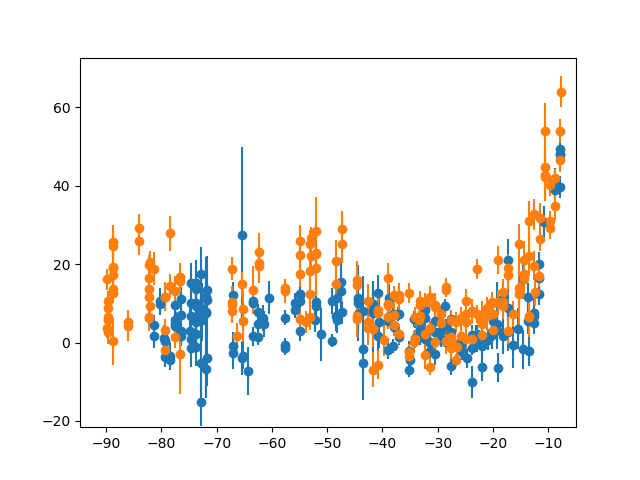

In [91]:
plt.figure()
for fcqfid in np.unique(fcqfid_data):
    this_chip = np.where(fcqfid_data == fcqfid)
    plt.errorbar(t_data[this_chip], f_data[this_chip], f_unc_data[this_chip], fmt='o')            

In [22]:
r_max

7.33978524091219e-08